In [1]:
from a3py import *
import scipy as sp

# Spectral Subtration
In this notebook we are going to perform audio denoising by spectral subtraction.
The idea behind spectral subtraction is:
- First estimate the power spectrum of noise in an audio clip
- Subtract the magnitude of our estimated noise from each time slice in a stft
- Calculate the istft to get a denoised audio signal

You will make heavy use of the helper class [`a3py.STFT`](../a3py/a3py/STFT.py), which has been provided for you:

[`https://github.coecis.cornell.edu/CS6682-Spring2021/a3_audio_and_pointline/blob/main/a3py/a3py/STFT.py`](https://github.coecis.cornell.edu/CS6682-Spring2021/a3_audio_and_pointline/blob/main/a3py/a3py/STFT.py)

## Input Audio
Let's start off by opening an audio file. I've provided an example audio file, `./noisyhellocs6682`, for you to testt on, but I want you to hand in the result of spectral subtraction on your own audio for your submission. Specifically, use the notebook [./MySpectralSubtraction.ipynb](./MySpectralSubtraction.ipynb) to generate what you will be handing in.

In [2]:
a = Audio('./noisyhellocs6682.wav');
a.play()
a.showSpectrogram();

## Estimating The Noise Spectrum

To estimate the noise spectrum, we want to pick out a span of time from the original audio that only has background noise. An easy way to do this is to look at the spectrogram for a start and end time with no speech in between.

When you run this on your own sound, be sure to record a few seconds of background noise for this purpose.

In [3]:
noise_start = 8.5;
noise_end = 12;

def showNoiseClip(audio, noise_start, noise_end):
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=[12,4]);
    orig_ax = axs[0];
    noise_ax= axs[1];
    audio.showSpectrogram(fig = fig, ax=orig_ax);
    orig_ax.set(title='Original Signal')
    lineargs = dict(linewidth=3, color='green');
    orig_ax.axvline(x=noise_start, **lineargs);
    orig_ax.axvline(x=noise_end, **lineargs);

    noise = audio.GetClip(noise_start, noise_end);
    noise.showSpectrogram(fig=fig, ax=noise_ax);
    noise_ax.set(title='Noise Spectrogram')
    print("Selected Noise Audio:")
    noise.play()

showNoiseClip(a, noise_start, noise_end)


Selected Noise Audio:


## Clipping our noise sample
In our sample audio, 8.5s-12s is just background noise, so we will use that. We can use the helper function `audio.GetClip(start, end)` to clip our audio to a new Audio object.

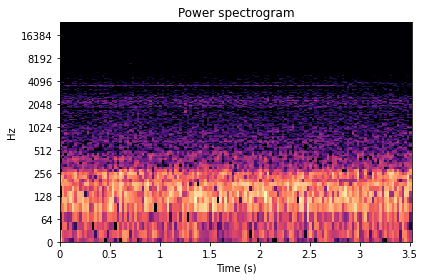

In [4]:
noise = a.GetClip(noise_start,noise_end);
noise.play();
noise.showSpectrogram();

# Your Code Goes Here!
Complete the following two functions to implement spectral subtraction. My implementation is 5 lines of code---yours may be more than that, but try not to make it *too* complicated.

In [81]:
def estimatePerFrequencyNoiseMagnitude(noise_stft):
    # estimate the magnitude of noise at each frequency in a noise-only stft.
    # the return value should be an np.ndarray of lenth equal to the number of frequencies in noise_stft
    # taking the average magnitude for each frequency should do fine...
    
    n_mag = noise_stft.mag;
#     n_mean_mag = np.mean(n_mag);
    n_mean_mag = np.mean(n_mag, axis=1);
    return n_mean_mag;

def GetSTFTDenoisedWithSpectralSubtraction(input_stft, estimated_noise_magnitudes):
    # Return a copy of the input_stft that has been denoised with spectral subtraction using the noise magnitude estimates in estimated_noise_magnitudes.
    # Remember not to end up with negative magnitudes.
    
    # calculate phase and magnitudes, and set them using setPhaseMag like so:    
    # rval = input_stft.clone();
    # rval.setPhaseMag(phase=, mag=);
    # return rval;
    
    rval = input_stft.clone();
    
    mags = np.subtract(rval.mag, estimated_noise_magnitudes[:,None]);
    mags = np.maximum(mags, 0);
#     plt.plot(mags);

    rval.setPhaseMag(phase=input_stft.phase, mag=mags);
    
    return rval;
    
#     raise NotImplementedError;

    
#Test
noise = a.GetClip(noise_start,noise_end);
noise_stft = STFT.FromAudio(noise);
noise_spec = estimatePerFrequencyNoiseMagnitude(noise_stft);
# plt.plot(noise_spec);
# plt.plot(noise_stft);

denoised = GetSTFTDenoisedWithSpectralSubtraction(noise_stft, noise_spec);
    
# noise_spec.view();
# noise.showSpectrogram();
# plt.plot(denoised);

In [82]:
def Denoise(input_stft, noise_stft):
    #estimate the noise spectrum
    noise_spec = estimatePerFrequencyNoiseMagnitude(noise_stft);

    #input stft denoised with estimate based on noise
    stft_denoised = GetSTFTDenoisedWithSpectralSubtraction(input_stft, noise_spec);
    
    #denoised audio
    denoised = stft_denoised.GetISTFTAudio();
    return denoised;
    


In [91]:
def displayResults(input_audio, noise_start, noise_end):
    noise_clip = input_audio.GetClip(noise_start, noise_end);
    #input stft
    input_stft = STFT.FromAudio(input_audio);
    #noise stft
    noise_stft = STFT.FromAudio(noise_clip);

    denoised = Denoise(input_stft, noise_stft);
    stft_denoised = STFT.FromAudio(denoised);
    
    fig, axs = plt.subplots(nrows=2,ncols=2,figsize=[10,6]);
    orig_ax = axs[0][0];
    noise_ax= axs[0][1];
    denoised_ax = axs[1][0];
    noisespec_ax = axs[1][1];

    input_stft.showPower(fig = fig, ax=orig_ax);
    orig_ax.set(title='Original Signal')
    lineargs = dict(linewidth=3, color='green');
    orig_ax.axvline(x=noise_start, **lineargs);
    orig_ax.axvline(x=noise_end, **lineargs);

    noise_stft.showPower(fig = fig, ax=noise_ax);
    noise_ax.set(title='Noise Sample ({}s-{}s)'.format(noise_start, noise_end))

    denoised.showSpectrogram(fig=fig, ax=denoised_ax);
    denoised_ax.set(title='Denoised Signal');

    plt.plot(stft_denoised.freqs, estimatePerFrequencyNoiseMagnitude(noise_stft));
    noisespec_ax.set(title='Estimated Noise Spectrum');

    print("Original:")
    input_audio.play(); #little error, was a
    print("Denoised:")
    denoised.play()


Original:


Denoised:


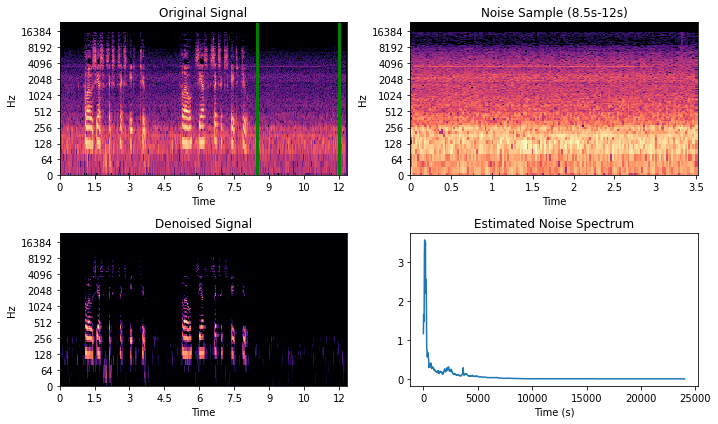

In [92]:
displayResults(a, noise_start, noise_end)

# Run things on your own audio!
Run the same process below on some audio that you record.

In [93]:
myaudio = Audio('./ben_noisynoisetest.wav');
myaudio.play()

my_noise_start = 2.0;
my_noise_end = 3.5;

showNoiseClip(myaudio, my_noise_start, my_noise_end)

Selected Noise Audio:


Original:


Denoised:


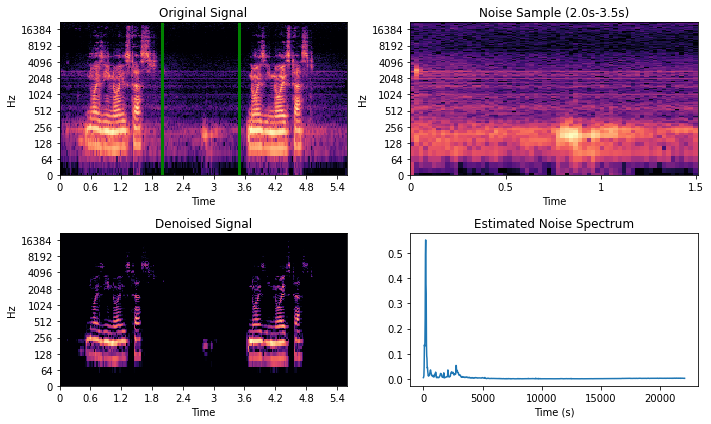

In [94]:
displayResults(myaudio, my_noise_start, my_noise_end)

# What to turn in
Run this entire notebook when you have completed it (with your implementation and denoised audio results included). Download the completed notebook as HTML, and submit it on CMS.